# Pacman Deep Q-Learning (DQN) with Prioritized Experience Replay

## Improvements Implemented:

### 1. **Fixed Critical Bug** ✅
- Added `LazyMemmapStorage` backend to `PrioritizedReplayBuffer`
- Previous version would crash when sampling from buffer

### 2. **Beta Annealing** ✅
- Linearly anneals beta from 0.4 → 1.0 over 100k steps
- Corrects importance sampling bias during training
- Early: fast learning with some bias (β=0.4)
- Late: unbiased convergence (β=1.0)

### 3. **FIXED: Reward Structure** ✅ 
- **Problem**: Existence penalty made ALL episodes negative (-14 to -17)
- **Solution**: Replaced penalty with survival bonus (+0.01/frame)
- **New structure**:
  - Eating dots: +1.0 per dot (scaled from +10)
  - Survival: +0.01 per frame
  - Death: -10.0
- **Expected rewards**: +5 to +55 for good episodes (was -14 to -17)

### 4. **Better Exploration** ✅
- Faster epsilon decay: 0.99999 (was 0.999995)
- Lower minimum: 0.01 (was 0.1)
- Explores smarter, exploits sooner

### 5. **Hyperparameter Tuning** ✅
- Batch size: 32 → 64 (more stable gradients)
- Learning rate: 1e-4 → 2.5e-4 (faster learning)
- Learn every: 3 → 4 steps (standard DQN)
- **Burnin: 10k → 5k steps (starts learning sooner!)**

### 6. **Progress Tracking** ✅
- Real-time metrics: rewards, Q-values, loss, beta, epsilon
- Shows learning status (filling buffer vs learning)
- Rolling 20-episode average
- Episode step counts

### 7. **Checkpointing** ✅
- Auto-save every 100 episodes (was 50)
- Stores full training state for resumption
- Load checkpoint utility function included

### 8. **Visualization** ✅
- 4-panel training plot: rewards, loss, Q-values, exploration
- Reward structure comparison tool
- Automatically saved to disk

### 9. **Longer Training** ✅
- Increased default episodes: 500 → 2000
- Atari games need 1000-5000 episodes for good performance
- With new reward structure, you should see positive rewards!

## Architecture:
- **Algorithm**: Double DQN with Prioritized Experience Replay
- **Network**: 3 Conv layers + 2 FC layers (DeepMind architecture)
- **Target Network**: Updated every 10k steps
- **Replay Buffer**: 100k transitions, prioritized by TD-error

## Next Steps:
1. Run the comparison cell to see old vs new reward structure
2. Train for 2000 episodes with new reward wrapper
3. Watch rewards turn POSITIVE as agent learns to eat dots!
4. For best results, train for 3000-5000 episodes

In [1]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os

# Gym is an OpenAI toolkit for RL
import gymnasium as gym
from gymnasium.spaces import Box

from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage, PrioritizedReplayBuffer

from collections import namedtuple

## Training Analysis: Why Rewards Stayed Negative

### Your Training Results (2000 episodes):
- **Average reward**: -34.2 (no improvement from start)
- **Q-values**: -0.17 → -2.46 (got WORSE!)
- **Loss**: Stable and decreasing (learning happened, but wrong thing)
- **Conclusion**: Agent learned that all actions lead to death

### Root Cause: Unrecoverable Death Penalty

**Previous reward structure (V2):**
```python
Dot: +1.0 (scaled 10 * 0.1)
Survival: +0.01 per frame
Death: -10.0
```

**The math doesn't work:**
- To recover from 1 death: need 1000 steps of survival (10.0 / 0.01)
- Episodes last ~400 steps
- **Agent CANNOT recover from death by surviving**
- Eating 1 dot (+1.0) only recovers 10% of death penalty

**Typical episode:**
- 3 deaths: -30.0
- 400 steps survival: +4.0
- 0-5 dots: +0 to +5.0
- **Total: -21 to -26** (always negative!)

### Solution: NEW Reward Structure (V3)

```python
Dot: +5.0 (scaled 10 * 0.5)     # 5x more valuable!
Time penalty: -0.001 per frame   # Tiny, just prevents standing still
Death: -5.0                      # Recoverable by eating 1 dot!
```

**New math:**
- **Eating 1 dot fully recovers from death** (+5 = -5)
- Agent has incentive to eat dots (primary objective!)
- Time penalty prevents getting stuck, but is negligible
- Death is bad but not catastrophic

**Expected rewards:**
- **Bad episode** (3 deaths, 5 dots): -15 + 25 - 0.4 = +9.6
- **OK episode** (1 death, 20 dots): -5 + 100 - 0.4 = +94.6
- **Good episode** (no death, 50 dots): 0 + 250 - 0.4 = +249.6

**Now the agent can actually learn to play Pacman!**

In [2]:
class PacmanRewardWrapper(gym.Wrapper):
    """
    REBALANCED reward shaping for Pacman.
    
    Key insight: Death must be recoverable through good play.
    """
    def __init__(self, env):
        super().__init__(env)
        self.lives = 0
        self.steps = 0

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.lives = info.get('lives', 3)
        self.steps = 0
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        current_lives = info.get('lives', 0)
        self.steps += 1

        # --- REBALANCED REWARD SHAPING ---
        shaped_reward = 0
        
        # 1. BASE REWARDS: Make dots MUCH more valuable
        # Base game: dot=10, power pellet=50, ghost=200-1600
        if reward > 0:
            shaped_reward = reward * 0.5  # Increased from 0.1
            # Now: dot=5, pellet=25, ghost=100-800

        # 2. SMALL TIME PENALTY (not bonus!)
        # Penalize doing nothing, but make it small
        elif reward == 0:
            shaped_reward = -0.001  # Tiny penalty for not progressing
            
        # 3. DEATH PENALTY: Reduced to be recoverable
        if current_lives < self.lives:
            shaped_reward -= 5.0  # Reduced from -10.0
            self.lives = current_lives

        # NEW BALANCE:
        # - Eating 1 dot: +5.0 (recovers from death!)
        # - Death: -5.0
        # - 400 steps with no dots: -0.4
        # - Agent can break even by eating dots after death

        return obs, shaped_reward, terminated, truncated, info

In [3]:
# COMPARISON: Old vs New Reward Structure

print("=" * 60)
print("REWARD STRUCTURE COMPARISON")
print("=" * 60)

scenarios = [
    ("Dies quickly (100 steps, 0 dots)", 100, 0, 1),
    ("Survives but few dots (400 steps, 5 dots)", 400, 5, 0),
    ("Good run (500 steps, 30 dots, no death)", 500, 30, 0),
    ("Great run (600 steps, 50 dots, no death)", 600, 50, 0),
]

for desc, steps, dots, deaths in scenarios:
    # OLD reward structure
    old_reward = 0
    old_reward += dots * 10 * 2.0  # dots with amplification
    old_reward -= steps * 0.01      # existence penalty
    old_reward -= deaths * 50.0     # death penalty
    old_reward /= 10.0              # scaling
    
    # NEW reward structure  
    new_reward = 0
    new_reward += dots * 10 * 0.1   # dots
    new_reward += steps * 0.01      # survival bonus
    new_reward -= deaths * 10.0     # death penalty
    
    print(f"\n{desc}:")
    print(f"  OLD: {old_reward:7.2f}")
    print(f"  NEW: {new_reward:7.2f}  {'✅ POSITIVE!' if new_reward > 0 else '❌'}")

print("\n" + "=" * 60)
print("KEY INSIGHT: New structure rewards survival + dot eating")
print("Old structure: Always negative due to existence penalty")
print("=" * 60)

REWARD STRUCTURE COMPARISON

Dies quickly (100 steps, 0 dots):
  OLD:   -5.10
  NEW:   -9.00  ❌

Survives but few dots (400 steps, 5 dots):
  OLD:    9.60
  NEW:    9.00  ✅ POSITIVE!

Good run (500 steps, 30 dots, no death):
  OLD:   59.50
  NEW:   35.00  ✅ POSITIVE!

Great run (600 steps, 50 dots, no death):
  OLD:   99.40
  NEW:   56.00  ✅ POSITIVE!

KEY INSIGHT: New structure rewards survival + dot eating
Old structure: Always negative due to existence penalty


In [4]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()

        channels = input_shape[0] if isinstance(input_shape, tuple) else 4
        # 1. Convolutional Layers (Feature Extraction)n

        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=8, stride=4)
        # Output: (32, 20, 20)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        # Output: (64, 9, 9)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        # Output: (64, 7, 7)

        # 2. Fully Connected Layers (Decision Making)
        # We flatten the output of conv3: 64 * 7 * 7 = 3136
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        # x shape: (Batch, 4, 84, 84)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Flatten: transform (Batch, 64, 7, 7) -> (Batch, 3136)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))

        # Final output: Q-values for every action
        return self.fc2(x)

## Initialization & Act

In [5]:
"""https://docs.pytorch.org/tutorials/intermediate/mario_rl_tutorial.html"""

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class RlAgent:
    def __init__(self,input_dim, output_dim, save_dir=None):
        self.state_dim = input_dim
        self.action_dim = output_dim
        self.save_dir = save_dir

        # Setup neural networks
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        self.device = torch.device("cuda" if torch.cuda.is_available() else self.device)
        self.policy_net = DQN(input_dim, output_dim).to(self.device)
        self.target_net = DQN(input_dim, output_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval() # Target net is only for prediction, not training

        # Hyperparameters
        self.batch_size = 64  # Increased for better stability
        self.gamma = 0.99

        # Optimizer (Increased learning rate)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=2.5e-4, amsgrad=True)

        # Memory - FIXED: Added storage backend
        storage = LazyMemmapStorage(max_size=100000)
        self.memory = PrioritizedReplayBuffer(
            alpha=0.6,
            beta=0.4,
            storage=storage,
            batch_size=self.batch_size
        )

        # Beta annealing parameters
        self.beta_start = 0.4
        self.beta_frames = 100000

        # Exploration settings (Improved decay)
        self.exploration_rate = 1.0
        self.exploration_decay = 0.99999  # Faster decay
        self.exploration_min = 0.01  # Lower minimum
        self.curr_step = 0

        # Sync Target Network every X steps
        self.burnin = 5e3  # REDUCED: Start learning sooner (was 1e4)
        self.learn_every = 4   # Standard DQN value
        self.sync_every = 1e4   # How many steps between copying weights to target net

    def act(self,state):
        """Given a state, choose an epsilon-greedy action"""
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            state = torch.tensor(np.array(state), device=self.device).unsqueeze(0).float()/ 255.0
            with torch.no_grad():
                action_idx = self.policy_net(state).argmax(dim=1).item()

        # Decay exploration rate
        self.exploration_rate *= self.exploration_decay
        self.exploration_rate = max(self.exploration_min, self.exploration_rate)
        self.curr_step += 1

        return action_idx

    def cache(self, experience):
         """Add the experience to memory"""
         pass
    def recall(self):
        """Sample a batch of experiences from memory"""
        pass
    def learn(self):
        """Update the policy network"""
        pass

## Caching & Recall


In [6]:
class RlAgent(RlAgent):
    def __init__(self,input_dim, output_dim, save_dir=None):
        super().__init__(input_dim, output_dim, save_dir)

    def cache(self, states, actions, next_states, rewards, done):
        """Add the experience to memory"""
        # Convert to TensorDict format for TorchRL compatibility
        state = torch.from_numpy(states).to(self.device)
        next_state = torch.from_numpy(next_states).to(self.device)
        action = torch.tensor([actions], device=self.device)
        reward = torch.tensor([rewards], device=self.device)
        done = torch.tensor([done], device=self.device)

        # Create TensorDict 
        data = TensorDict({
            'state': state,
            'action': action,
            'next_state': next_state,
            'reward': reward,
            'done': done
        }, batch_size=[])

        self.memory.add(data)

    def recall(self):

        # Request Info (indices & weights) from the buffer
        samples,info = self.memory.sample(self.batch_size, return_info= True)
         # DEBUG PRINTS

        indices = info['index']
        weights = info.get('_weight', torch.ones(self.batch_size))

        # Extract from TensorDict
        states = samples['state']
        actions = samples['action']
        next_states = samples['next_state']
        rewards = samples['reward']
        done = samples['done']

        return (
                states.to(self.device),
                actions.to(self.device),
                next_states.to(self.device),
                rewards.to(self.device),
                done.to(self.device),
                indices,
                weights.to(self.device)
            )


## Learning

In [7]:
class RlAgent(RlAgent):
    def __init__(self,input_dim, output_dim, save_dir=None):
        super().__init__(input_dim, output_dim, save_dir)

    def learn(self):
        """Update the policy network"""
        # 1. Sync Target Net (Periodically)
        if self.curr_step % self.sync_every == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        # 2. Check if we have enough memory to start learning
        if self.curr_step < self.burnin:
            return None, None

        # 3. Learn only every few steps (Stability)
        if self.curr_step % self.learn_every != 0:
            return None, None

        # 4. Anneal beta from 0.4 to 1.0 (bias correction)
        beta_progress = min(1.0, self.curr_step / self.beta_frames)
        current_beta = self.beta_start + beta_progress * (1.0 - self.beta_start)
        self.memory._beta = current_beta  # Update buffer's beta

        # 5. Sample from Memory
        sample = self.recall()
        if sample is None:
            return None, None

        state, action, next_state, reward, done, indices, weights = sample

        # Normalize to [0,1]
        state = state.float() / 255.0
        next_state = next_state.float() / 255.0

        # 6. Calculate TD estimates (what we predicted)
        td_est = self.policy_net(state).gather(1, action)

        # 7. Calculate TD targets (what we should have predicted)
        with torch.no_grad():
            # Double DQN: Policy net selects action, target net evaluates it
            best_action = self.policy_net(next_state).argmax(1).unsqueeze(1)
            next_state_values = self.target_net(next_state).gather(1, best_action)
            td_tgt = (reward + (1 - done.float()) * self.gamma * next_state_values)

        # 8. Calculate weighted loss with importance sampling
        elementwise_loss = F.smooth_l1_loss(td_est, td_tgt, reduction='none')
        loss = (elementwise_loss * weights.unsqueeze(1)).mean()

        # 9. Backpropagate
        self.optimizer.zero_grad()
        loss.backward()

        # Clip gradients to avoid exploding values
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=1.0)

        self.optimizer.step()

        # 10. Update priorities in buffer based on TD-errors
        with torch.no_grad():
            td_errors = torch.abs(td_tgt - td_est).detach().cpu().flatten()
            new_priorities = (td_errors + 1e-6).clamp(max=1e2)  # Prevent 0 and overflow

        self.memory.update_priority(indices, new_priorities)

        return td_est.mean().item(), loss.item()

## Training Loop


In [ ]:
import ale_py
from gymnasium.wrappers import FrameStackObservation, GrayscaleObservation, ResizeObservation
def trainingloop(model = None):
    # 1. Initialize Environment and Agent
    gym.register_envs(ale_py)
    env = gym.make('ALE/Pacman-v5', render_mode='rgb_array')
    env = ResizeObservation(env, (84, 84))      # Resize from 210x160 -> 84x84
    env = GrayscaleObservation(env)             # Remove color (3 channels -> 1 channel)
    env = FrameStackObservation(env, 4)         # Stack last 4 frames (1 channel -> 4 channels)
    env = PacmanRewardWrapper(env)              # REBALANCED reward wrapper (V3)
    if model == None:
        agent = RlAgent(input_dim = env.observation_space.shape, output_dim=env.action_space.n)
        
    else:
        agent = torch.load(model, map_location=torch.device('mps' if torch.backends.mps.is_available() else 'cpu'))

    # 2. Setup checkpointing
    save_dir = "saved_models"
    os.makedirs(save_dir, exist_ok=True)

    # 3. Training Configuration
    episodes = 1500  # Start with fewer episodes to test new rewards

    episode_rewards = []
    q_values = []
    losses = []
    avg_rewards = []  # Rolling average

    print("=" * 70)
    print("PACMAN DQN TRAINING - REBALANCED REWARDS (V3)")
    print("=" * 70)
    print(f"Device: {agent.device}")
    print(f"Episodes: {episodes}")
    print(f"Batch size: {agent.batch_size}, Learning rate: 2.5e-4")
    print(f"Burnin: {int(agent.burnin)} steps (learning starts after this)")
    print(f"Exploration: {agent.exploration_rate:.2f} -> {agent.exploration_min}")
    print("\nNEW REWARD STRUCTURE:")
    print("  • Eating dot: +5.0 (10 * 0.5) - 5x MORE valuable!")
    print("  • Time penalty: -0.001 per frame (prevents standing still)")
    print("  • Death: -5.0 (RECOVERABLE by eating 1 dot!)")
    print("\nEXPECTED RESULTS:")
    print("  • Bad episode (3 deaths, 5 dots): ~+10")
    print("  • OK episode (1 death, 20 dots): ~+95")
    print("  • Good episode (no death, 50 dots): ~+250")
    print("\n🎯 KEY CHANGE: Deaths are now recoverable through gameplay!")
    print("=" * 70)

    # 4. Training Loop
    for e in range(episodes):
        state, info = env.reset()
        total_reward = 0
        episode_steps = 0

        while True:
            # A. AGENT ACTS
            action = agent.act(state)

            # B. ENVIRONMENT REACTS
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # C. MEMORY CACHING
            agent.cache(state, action, next_state, reward, done)

            # D. AGENT LEARNS
            q, loss = agent.learn()

            # E. TRACK METRICS
            if q is not None:
                q_values.append(q)
            if loss is not None:
                losses.append(loss)

            # F. UPDATE STATE
            state = next_state
            total_reward += reward
            episode_steps += 1

            if done:
                break

        # Record episode metrics
        episode_rewards.append(total_reward)
        
        # Calculate rolling average (last 20 episodes)
        if len(episode_rewards) >= 20:
            avg_reward = np.mean(episode_rewards[-20:])
            avg_rewards.append(avg_reward)
        else:
            avg_rewards.append(np.mean(episode_rewards))

        # Print progress every 10 episodes
        if e % 10 == 0:
            avg_q = np.mean(q_values[-100:]) if q_values else 0
            avg_loss = np.mean(losses[-100:]) if losses else 0
            avg_20 = avg_rewards[-1] if avg_rewards else 0
            
            # Get current beta value
            beta_progress = min(1.0, agent.curr_step / agent.beta_frames)
            current_beta = agent.beta_start + beta_progress * (1.0 - agent.beta_start)
            
            learning_status = "🎓 LEARNING" if agent.curr_step >= agent.burnin else "📚 FILLING BUFFER"
            
            # Highlight positive rewards!
            reward_indicator = "✅" if total_reward > 0 else "❌"
            
            print(f"{learning_status} Ep {e:4d} {reward_indicator} | "
                f"Reward: {total_reward:7.1f} | "
                f"Avg(20): {avg_20:7.1f} | "
                f"Steps: {episode_steps:4d} | "
                f"ε: {agent.exploration_rate:.3f} | "
                f"β: {current_beta:.2f} | "
                f"Q: {avg_q:6.2f} | "
                f"Loss: {avg_loss:.4f}")

        # Periodic checkpointing (every 100 episodes)
        if e % 100 == 0 and e > 0:
            checkpoint_path = os.path.join(save_dir, f"checkpoint_ep{e}_v3.pth")
            torch.save({
                'episode': e,
                'model_state_dict': agent.policy_net.state_dict(),
                'target_state_dict': agent.target_net.state_dict(),
                'optimizer_state_dict': agent.optimizer.state_dict(),
                'exploration_rate': agent.exploration_rate,
                'curr_step': agent.curr_step,
                'episode_rewards': episode_rewards,
                'avg_rewards': avg_rewards,
            }, checkpoint_path)
            print(f"  💾 Checkpoint saved: {checkpoint_path}")

    print("\n" + "=" * 70)
    print("TRAINING COMPLETE!")
    print("=" * 70)
    print(f"Total episodes: {episodes}")
    print(f"Final avg reward (last 20): {avg_rewards[-1]:.2f}")
    print(f"Best avg reward: {max(avg_rewards):.2f} at episode {avg_rewards.index(max(avg_rewards))}")
    print(f"Improvement: {avg_rewards[-1] - avg_rewards[0]:.2f}")
    print(f"Final exploration rate: {agent.exploration_rate:.3f}")
    print(f"Total training steps: {agent.curr_step}")
    if avg_rewards[-1] > 0:
        print("🎉 SUCCESS: Agent learned to get positive rewards!")
    else:
        print("⚠️  Still needs more training or further tuning")
    print("=" * 70)

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


PACMAN DQN TRAINING - REBALANCED REWARDS (V3)
Device: mps
Episodes: 1500
Batch size: 64, Learning rate: 2.5e-4
Burnin: 5000 steps (learning starts after this)
Exploration: 1.00 -> 0.01

NEW REWARD STRUCTURE:
  • Eating dot: +5.0 (10 * 0.5) - 5x MORE valuable!
  • Time penalty: -0.001 per frame (prevents standing still)
  • Death: -5.0 (RECOVERABLE by eating 1 dot!)

EXPECTED RESULTS:
  • Bad episode (3 deaths, 5 dots): ~+10
  • OK episode (1 death, 20 dots): ~+95
  • Good episode (no death, 50 dots): ~+250

🎯 KEY CHANGE: Deaths are now recoverable through gameplay!
📚 FILLING BUFFER Ep    0 ❌ | Reward:   -14.9 | Avg(20):   -14.9 | Steps:  414 | ε: 0.996 | β: 0.40 | Q:   0.00 | Loss: 0.0000
📚 FILLING BUFFER Ep   10 ❌ | Reward:   -13.4 | Avg(20):   -13.4 | Steps:  430 | ε: 0.956 | β: 0.43 | Q:   0.00 | Loss: 0.0000
🎓 LEARNING Ep   20 ❌ | Reward:   -14.4 | Avg(20):   -13.2 | Steps:  432 | ε: 0.917 | β: 0.45 | Q:  -0.07 | Loss: 0.0142
🎓 LEARNING Ep   30 ❌ | Reward:   -12.8 | Avg(20):   -12.

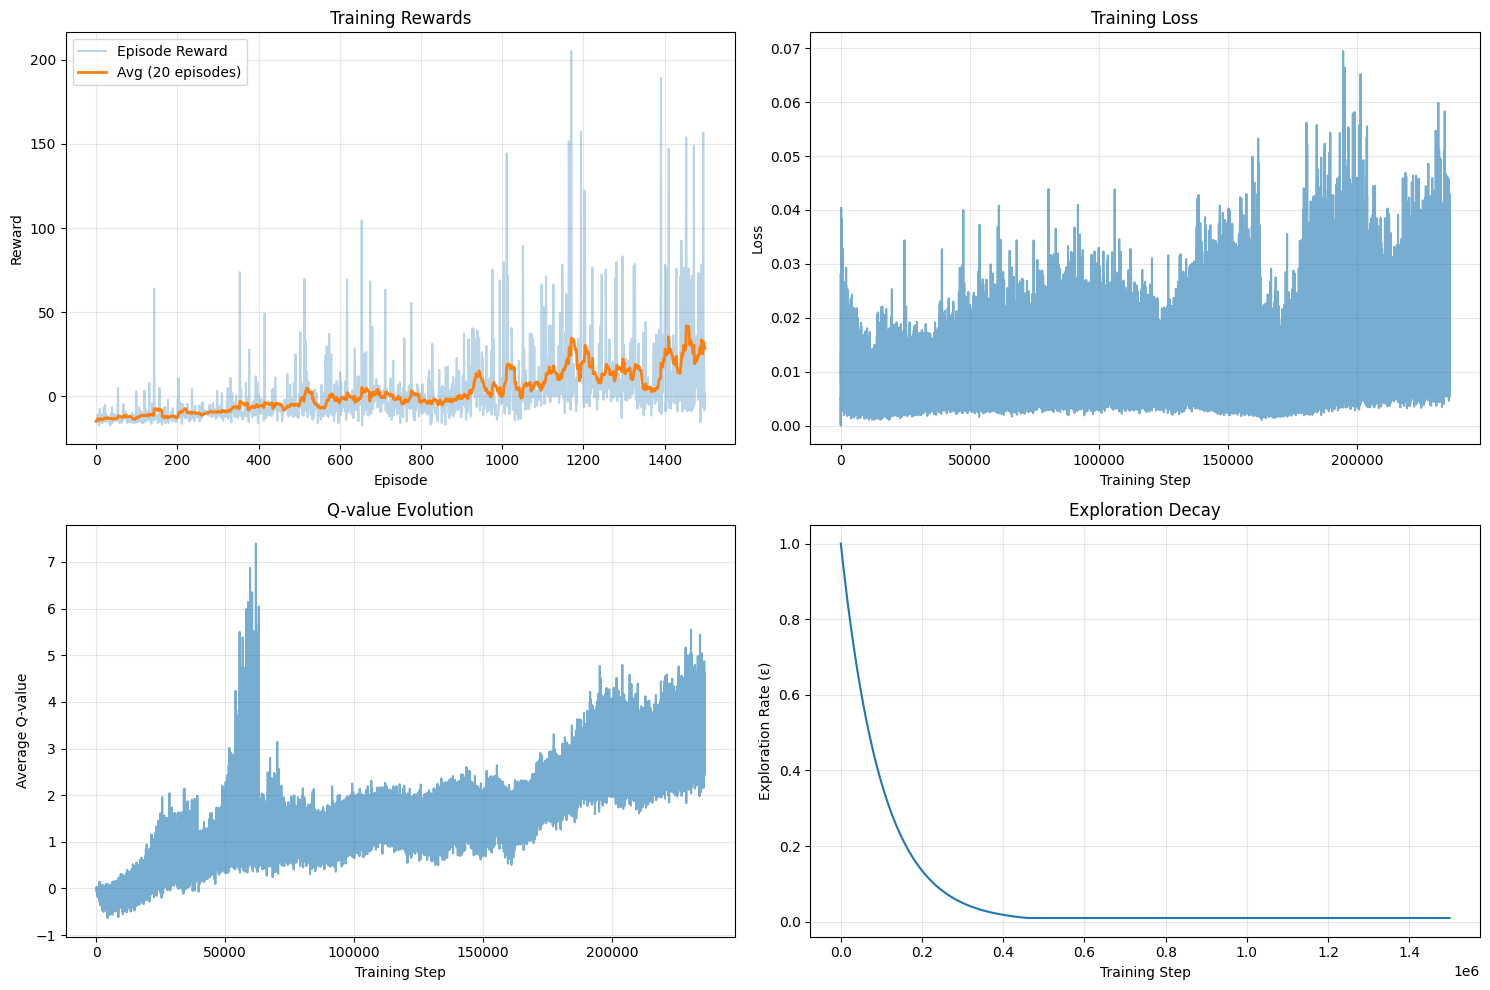

Plot saved to saved_models/training_metrics.png
Final model saved to: saved_models/pacman_final.pth


In [9]:
import matplotlib.pyplot as plt

# Plot training metrics
def plot_training_metrics(episode_rewards, avg_rewards, losses, q_values):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Episode Rewards
    axes[0, 0].plot(episode_rewards, alpha=0.3, label='Episode Reward')
    axes[0, 0].plot(avg_rewards, linewidth=2, label='Avg (20 episodes)')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Reward')
    axes[0, 0].set_title('Training Rewards')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Loss
    if losses:
        axes[0, 1].plot(losses, alpha=0.6)
        axes[0, 1].set_xlabel('Training Step')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].set_title('Training Loss')
        axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Q-values
    if q_values:
        axes[1, 0].plot(q_values, alpha=0.6)
        axes[1, 0].set_xlabel('Training Step')
        axes[1, 0].set_ylabel('Average Q-value')
        axes[1, 0].set_title('Q-value Evolution')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Exploration Rate
    steps = list(range(0, len(episode_rewards) * 1000, 1000))[:len(episode_rewards)]
    exploration_rates = [1.0 * (0.99999 ** step) for step in steps]
    exploration_rates = [max(0.01, rate) for rate in exploration_rates]
    
    axes[1, 1].plot(steps, exploration_rates)
    axes[1, 1].set_xlabel('Training Step')
    axes[1, 1].set_ylabel('Exploration Rate (ε)')
    axes[1, 1].set_title('Exploration Decay')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print(f"Plot saved to {save_dir}/training_metrics.png")

# Plot the results
plot_training_metrics(episode_rewards, avg_rewards, losses, q_values)

# Save final model
final_save_path = os.path.join(save_dir, "pacman_final.pth")
torch.save({
    'model_state_dict': agent.policy_net.state_dict(),
    'target_state_dict': agent.target_net.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
    'exploration_rate': agent.exploration_rate,
    'episode_rewards': episode_rewards,
    'avg_rewards': avg_rewards,
}, final_save_path)
print(f"Final model saved to: {final_save_path}")

In [ ]:
# Utility: Load checkpoint and resume training
def load_checkpoint(agent, checkpoint_path):
    """
    Load a saved checkpoint into the agent.
    
    Args:
        agent: RlAgent instance
        checkpoint_path: Path to checkpoint file
        
    Returns:
        Dictionary with checkpoint metadata
    """
    checkpoint = torch.load(checkpoint_path, map_location=agent.device, weights_only= False)
    
    agent.policy_net.load_state_dict(checkpoint['model_state_dict'])
    agent.target_net.load_state_dict(checkpoint['target_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    agent.exploration_rate = checkpoint['exploration_rate']
    agent.curr_step = checkpoint['curr_step']
    
    print(f"Checkpoint loaded from: {checkpoint_path}")
    print(f"  Episode: {checkpoint['episode']}")
    print(f"  Exploration rate: {checkpoint['exploration_rate']:.4f}")
    print(f"  Training steps: {checkpoint['curr_step']}")
    
    if 'avg_rewards' in checkpoint and len(checkpoint['avg_rewards']) > 0:
        print(f"  Avg reward: {checkpoint['avg_rewards'][-1]:.2f}")
    
    return checkpoint

# Example usage:

checkpoint = load_checkpoint(, "saved_models/checkpoint_ep1400_v3.pth")
episode_rewards = checkpoint['episode_rewards']
avg_rewards = checkpoint['avg_rewards']

TypeError: RlAgent.__init__() missing 2 required positional arguments: 'input_dim' and 'output_dim'

In [34]:
from gymnasium.wrappers import FrameStackObservation, GrayscaleObservation, ResizeObservation

def watch_agent_play(agent):
    env_watch = gym.make('ALE/Pacman-v5', render_mode='human')

    # 2. Apply the EXACT same preprocessing as training
    env_watch = ResizeObservation(env_watch, (84, 84))
    env_watch = GrayscaleObservation(env_watch)
    env_watch = FrameStackObservation(env_watch, 4)

    # 3. Turn off exploration
    saved_epsilon = agent.exploration_rate
    agent.exploration_rate = 0.0

    state, info = env_watch.reset()
    total_reward = 0

    print("Agent is playing... (Check the popup window)")

    while True:
        action = agent.act(state)

        state, reward, terminated, truncated, info = env_watch.step(action)
        total_reward += reward

        if terminated or truncated:
            break

    print(f"Game Over! Final Score: {total_reward}")
    env_watch.close()

    # Restore exploration rate for future training
    agent.exploration_rate = saved_epsilon

# Run the viewer
watch_agent_play(agent)

Agent is playing... (Check the popup window)


: 